In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

print('finished importing')

finished importing


In [25]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

In [26]:
batch_size: int = 64

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size, shuffle=True)

for X, y in test_data_loader:
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.dtype}')
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.int64


# Creating Models

To define a neural network in PyTorch, we create a class that inherits from `nn.Module`.

We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function.

To accelerate operations in the neural network, we move it to the GPU if available.

In [27]:
# Get cpu or gpu device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Define model
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


# Optimizing the Model Parameters

To train a model, we need a loss function and an optimizer.

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), 
and backpropagates the prediction error to adjust the models parameters.

In [34]:
def train(dataloader: DataLoader, model: NeuralNetwork, loss_fn: nn.CrossEntropyLoss, optimizer: torch.optim.SGD) -> None:
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

# We also check the models performance against the test dataset to ensure it is learning
def test(dataloader: DataLoader, model: NeuralNetwork) -> None:
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

# Training Process

The training process is conducted over several iterations (epochs).

During each epoch, the model learns parameters to make better predictions.

We print the models accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with each epoch.

In [36]:
epochs: int = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_data_loader, model)

print('Done!')

Epoch 1
-------------------------------
loss: 1.557994  [    0/60000]
loss: 1.619909  [ 6400/60000]
loss: 1.544233  [12800/60000]
loss: 1.537938  [19200/60000]
loss: 1.671318  [25600/60000]
loss: 1.328589  [32000/60000]
loss: 1.499629  [38400/60000]
loss: 1.555724  [44800/60000]
loss: 1.407366  [51200/60000]
loss: 1.257112  [57600/60000]
Test Error: 
 Accuracy: 57.0%, Avg loss: 0.022893 

Epoch 2
-------------------------------
loss: 1.480981  [    0/60000]
loss: 1.520786  [ 6400/60000]
loss: 1.467285  [12800/60000]
loss: 1.327206  [19200/60000]
loss: 1.412159  [25600/60000]
loss: 1.182305  [32000/60000]
loss: 1.459795  [38400/60000]
loss: 1.825525  [44800/60000]
loss: 1.446987  [51200/60000]
loss: 1.385465  [57600/60000]
Test Error: 
 Accuracy: 57.7%, Avg loss: 0.021396 

Epoch 3
-------------------------------
loss: 1.463294  [    0/60000]
loss: 1.298506  [ 6400/60000]
loss: 1.243092  [12800/60000]
loss: 1.159866  [19200/60000]
loss: 1.238205  [25600/60000]
loss: 1.053571  [32000/600

# Saving Models

A common way to save a model is to serialize the internal state dictionary (containing the model parameter).

In [37]:
torch.save(model.state_dict(), 'model.pth')

# Loading Models

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [38]:
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

# Predictions

This model can be used to make predictions.

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Iterating and Visualizing the Dataset

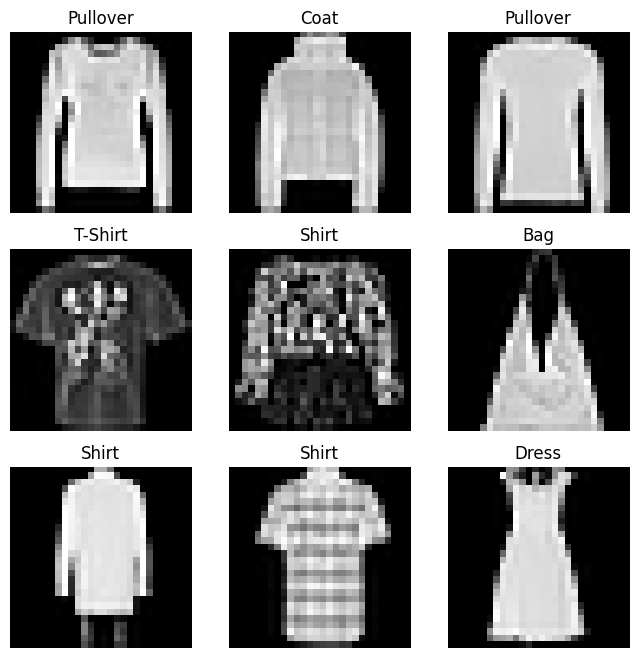

In [14]:
labels_map: dict = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

# Creating a Custom Dataset for your files (placeholder will be added later ![link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files))


# Preparing your data for training with DataLoaders

The `Dataset` retrieves our datasets features and labels one sample aat the time.

While training a model, we typically want to pass samples in 'minibatches',
reshuffle the data at every epoch to reduce model overfitting, 
and use Pythons `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity with an API.

# Iterate through the DataLoader

We have loaded that dataset into the `DataLoader` and can iterate through the dataset as needed.

Each iteration below returns a batch of `train_features` and `train_labels` (containing `batch_size=64` features and labels respectively).

Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at `Sampler`)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


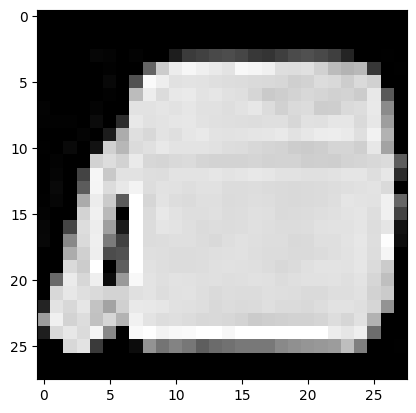

Label: 8


In [16]:
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')